In [10]:
from forgebox.imports import *
from transformers import AutoModel, AutoTokenizer, AutoConfig
from tqdm.notebook import tqdm
from typing import List, Type
from sklearn.svm import SVR
from forgebox.ftorch.cuda import CudaHandler
from sklearn.metrics import mean_squared_error
import pickle
import random
from torch.utils.data.dataloader import DataLoader, default_collate
from copy import deepcopy

In [11]:
os.environ["CUDA_LAUNCH_BLOCKING"]="1"

In [12]:
WEIGHTS = Path("/nvme/GCI/public/lit/weights")

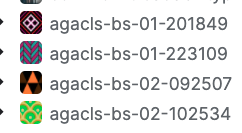

In [30]:
for slug in WEIGHTS.ls():
    if "AgainstCLS_bs_0" in slug:
        print(slug)
        print(len(list(f for f in (WEIGHTS/slug).iterdir() if "tar.gz" in f.name or ".pkl" in f.name)))

AgainstCLS_bs_02_154406
0
AgainstCLS_bs_01_233421
30
AgainstCLS_bs_02_092503
12
AgainstCLS_bs_01_222958
30
AgainstCLS_bs_01_233917
30
AgainstCLS_bs_01_201849
30
AgainstCLS_bs_01_200924
35
AgainstCLS_bs_02_154538
0
AgainstCLS_bs_02_102534
30
AgainstCLS_bs_02_092507
30
AgainstCLS_bs_01_223109
30


In [15]:
def save_configs(tag, save):
    config = AutoConfig.from_pretrained(tag)
    tokenizer = AutoTokenizer.from_pretrained(tag)
    tokenizer.save_pretrained(save/"tokenizer")
    config.save_pretrained(save/"config")
    return tokenizer, config

In [16]:
DEV = CudaHandler().idle().device

>>> 2 cuda devices found >>>
Device 0: 
	name:Tesla V100-PCIE-32GB
	used:20375MB	free:12135MB
Device 1: 
	name:Tesla V100-PCIE-32GB
	used:23231MB	free:9279MB
cuda stats refreshed
Found the most idle GPU: cuda:0, 12135 MB Mem remained


## Data

In [17]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [18]:
DO_PAIR = True
BATCH_SIZE = 32

In [19]:
class BaseDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.indices = df.index
        self.tokenizer = tokenizer

    def __len__(self,): return len(self.df)

    def __getitem__(self, idx):
        row_ = dict(self.df.loc[self.indices[idx]])
        row = dict((k, v) for k, v in row_.items()
                   if k in ["excerpt", "id", "target"])
        return row

    def collate(self, batch):
        batch = default_collate(batch)
        batch["excerpt"] = self.tokenizer(batch["excerpt"],
                                          truncation=True,
                                          return_tensors='pt',
                                          return_token_type_ids=False,
                                          padding=True,
                                          max_length=self.tokenizer.max_len_sentences_pair
                                          )
        if 'target' in batch:
            batch['target'] = batch['target'].float()
        return batch


class PairDataset(BaseDataset):
    def __init__(self, df, tokenizer):
        super().__init__(df, tokenizer)

    def __getitem__(self, idx):
        row_ = dict(self.df.loc[self.indices[idx]])
        row = dict((k, v) for k, v in row_.items()
                   if k in ["excerpt", "id", "target"])
        extra_text = dict(self.df.loc[random.choice(self.indices)])['excerpt']
        row['excerpt'] = str(row['excerpt'])+"[SEP]"+str(extra_text)
        return row


def split_k(df, k: int = 5):
    kmap = np.random.choice(range(k), size=len(df))
    return dict((ki, dict(train=(kmap != ki), valid=(kmap == ki))) for ki in range(5))


LitDataset = PairDataset if DO_PAIR else BaseDataset

In [20]:
def create_dl(df, tokenizer, ds_class, istrain = True) -> DataLoader:
    """
    Create dataloader from a dataframe
    """
    ds = ds_class(df, tokenizer)
    dl = DataLoader(ds, shuffle=False,
                    batch_size=BATCH_SIZE if istrain else BATCH_SIZE*2,num_workers=8,
                    collate_fn = ds.collate)
    return dl

### Splits

In [21]:
splits = split_k(train_df, 5)
splits


{0: {'train': array([ True,  True, False, ...,  True,  True,  True]),
  'valid': array([False, False,  True, ..., False, False, False])},
 1: {'train': array([ True,  True,  True, ...,  True,  True, False]),
  'valid': array([False, False, False, ..., False, False,  True])},
 2: {'train': array([ True, False,  True, ...,  True,  True,  True]),
  'valid': array([False,  True, False, ..., False, False, False])},
 3: {'train': array([False,  True,  True, ..., False,  True,  True]),
  'valid': array([ True, False, False, ...,  True, False, False])},
 4: {'train': array([ True,  True,  True, ...,  True, False,  True]),
  'valid': array([False, False, False, ..., False,  True, False])}}

## Model

In [22]:
class AttentionHead(nn.Module):
    def __init__(self, in_features, hidden_dim):
        super().__init__()
        self.in_features = in_features
        self.middle_features = hidden_dim

        self.W = nn.Linear(in_features, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)
        self.out_features = hidden_dim

    def forward(self, features):
        att = torch.tanh(self.W(features))
        score = self.V(att)
        attention_weights = torch.softmax(score, dim=1)
        context_vector = attention_weights * features
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector


class BaseModel(nn.Module):
    is_pair = False

    def __init__(self):
        super().__init__()
        self.is_acu_vec = False

    def vec_plus(self, vec):
        if self.is_acu_vec:
            self.vecs.append(vec.clone().cpu().numpy())

    def inference(
        lit_model, model_weights: Path, data_loader: DataLoader, filename: str
    ) -> None:
        lit_model.load_state_dict(torch.load(str(model_weights)), strict=False)
        lit_model = lit_model.eval()
        lit_model = lit_model.cuda(DEV)
        results = []
        for batch_idx, batch in tqdm(enumerate(data_loader), leave=False, total=len(data_loader)):
            ids = batch["id"]
            excerpt = batch["excerpt"]
            excerpt["input_ids"] = excerpt["input_ids"].cuda(DEV)
            excerpt["attention_mask"] = excerpt["attention_mask"].cuda(DEV)
            with torch.no_grad():
                y_ = lit_model(**excerpt)[:, 0].detach().cpu().numpy()
            results.append(pd.DataFrame({"id": ids, "target": y_}))
        pd.concat(results).to_csv(filename, index=False)
        lit_model.cpu()

    def vec_train_pred(
            lit_model, model_weights: Path, data_loader: DataLoader) -> None:
        state_dict = torch.load(str(model_weights))
        if "state_dict" in state_dict:
            state_dict = state_dict["state_dict"]
        lit_model.load_state_dict(state_dict, strict=False)
        lit_model = lit_model.eval()
        lit_model = lit_model.cuda(DEV)

        lit_model.vecs = []
        lit_model.targets = []
        lit_model.is_acu_vec = True
        for batch_idx, batch in tqdm(enumerate(data_loader), leave=False, total=len(data_loader)):
            ids = batch["id"]
            excerpt = batch["excerpt"]
            excerpt["input_ids"] = excerpt["input_ids"].cuda(DEV)
            excerpt["attention_mask"] = excerpt["attention_mask"].cuda(DEV)
            y = batch["target"]
            lit_model.targets.append(y)
            with torch.no_grad():
                vec = lit_model.get_vec(excerpt)
                lit_model.vec_plus(vec)
        lit_model.is_acu_vec = False
        lit_model.cpu()
        return lit_model.vecs

    def vec_test_pred(
        lit_model, model_weights: Path, data_loader: DataLoader, filename: str
    ) -> None:
        lit_model.load_state_dict(torch.load(str(model_weights)), strict=True)
        lit_model = lit_model.eval()
        lit_model = lit_model.cuda(DEV)
        results = []
        lit_model.vecs = []
        lit_model.is_acu_vec = True
        for batch_idx, batch in tqdm(
            enumerate(data_loader),
            leave=False,
            total=len(data_loader)):
            
            ids = batch["id"]
            excerpt = batch["excerpt"]
            excerpt["input_ids"] = excerpt["input_ids"].cuda(DEV)
            excerpt["attention_mask"] = excerpt["attention_mask"].cuda(DEV)
            with torch.no_grad():
                y_ = lit_model(**excerpt)[:, 0].detach().cpu().numpy()
            results.append(pd.DataFrame({"id": ids, "target": y_}))
        lit_model.is_acu_vec = False
        pd.concat(results).to_csv(filename, index=False)
        lit_model.cpu()
        return lit_model.vecs


class PairCLS(BaseModel):
    is_pair = True

    def __init__(self, base):
        super().__init__()
        self.base = base
        self.config = self.base.config
        self.reg = nn.Linear(base.config.hidden_size, 3)

    def get_vec(self, excerpt: torch.Tensor) -> torch.Tensor:
        return self.base(**excerpt).last_hidden_state[:, 0, :]

    def forward(self, **excerpt: torch.Tensor) -> torch.Tensor:
        vec = self.get_vec(excerpt)
        self.vec_plus(vec)
        return self.reg(vec)[:, :1]


class AgainstCLS(BaseModel):
    def __init__(self, base):
        super().__init__()
        self.base = base
        self.config = self.base.config
        self.reg = nn.Linear(base.config.hidden_size, 1)

    def get_vec(self, excerpt):
        return self.base(**excerpt).last_hidden_state[:, 0, :]

    def forward(self, **excerpt: torch.Tensor) -> torch.Tensor:
        vec = get_vec(**excerpt)
        return self.reg(vec)


class CLSReg(BaseModel):
    def __init__(self, base):
        super().__init__()
        self.base = base
        self.config = self.base.config
        self.reg = nn.Linear(base.config.hidden_size, 1)

    def forward(self, **excerpt: torch.Tensor) -> torch.Tensor:
        vec = self.get_vec(excerpt)
        self.vec_plus(vec)
        return self.reg(vec)

    def get_vec(self, excerpt: torch.Tensor) -> torch.Tensor:
        return self.base(**excerpt).last_hidden_state[:, 0, :]


class MeanPooler(BaseModel):
    def __init__(self, base):
        super().__init__()
        self.base = base
        self.config = self.base.config
        self.reg = nn.Linear(base.config.hidden_size, 1)
        self.dropout = nn.Dropout(.2)

    def reduce_hidden_state(self, vec, attention_mask):
        vec = vec*(attention_mask[..., None])
        return vec.sum(dim=1)/(attention_mask.sum(-1)[..., None])

    def forward(self, **excerpt: torch.Tensor) -> torch.Tensor:
        vec = self.get_vec(excerpt)
        self.vec_plus(vec)
        return self.reg(vec)

    def get_vec(self, excerpt):
        attention_mask = excerpt["attention_mask"]
        vecs = self.base(**excerpt).last_hidden_state
        return self.reduce_hidden_state(vecs, attention_mask)


class WithAttnHead(BaseModel):
    def __init__(self, base):
        super().__init__()
        self.base = base
        self.config = self.base.config
        self.head = AttentionHead(
            self.config.hidden_size,
            self.config.hidden_size)
        self.dout = nn.Dropout(.1)
        self.reg = nn.Linear(base.config.hidden_size, 1)

    def forward(self, **excerpt: torch.Tensor) -> torch.Tensor:
        vec = self.get_vec(excerpt)
        self.vec_plus(vec)
        return self.reg(self.dout(vec))

    def get_vec(self, excerpt: torch.Tensor) -> torch.Tensor:
        return self.head(self.base(**excerpt).last_hidden_state)


def merge_subs(subs: List[pd.DataFrame]) -> pd.DataFrame:
    concat = pd.concat(list(su.set_index("id") for su in subs), 1)
    return pd.DataFrame({"id": concat.index, "target": concat.values.mean(-1)})

In [23]:
def rmse(y_pred, y_true):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [24]:
def svming(lit_model, model_weights, train_dl, test_dl, weight_idx, fold_idx, C=10, kernel="rbf"):
    lit_model.vec_train_pred(model_weights, train_dl)
    x = np.concatenate(lit_model.vecs)
    y = np.concatenate(lit_model.targets)
    svm = SVR(C=C, kernel=kernel, gamma='auto')
    svm.fit(x, y)
    lit_model.vec_test_pred(
        model_weights, test_dl, filename=f"sub_w{weight_idx}_f{fold_idx}.csv")
    x_test = np.concatenate(lit_model.vecs)
    y_test = svm.predict(x_test)

    return pd.DataFrame({"id": list(test_dl.dataset.df["id"]), "target": y_test})


def svming_folds(
    lit_model, model_weights,
    train_dl, weight_idx, C=10, kernel="rbf"
):
    lit_model.vec_train_pred(model_weights, train_dl)
    x = np.concatenate(lit_model.vecs)
    y = np.concatenate(lit_model.targets)
    print(x[:5,:5])
    RMSEs = []
    for k, tv in splits.items():
        xtrain, ytrain = x[tv["train"]], y[tv["train"]]
        xtest, ytest = x[tv["valid"]], y[tv["valid"]]
        svm = SVR(C=C, kernel=kernel, gamma='auto')
        svm.fit(xtrain, ytrain)
        ytest_ = svm.predict(xtest)
        with (model_weights.parent/(f"{model_weights.name}_{k}.tar.gz")).open("wb") as f:
            pickle.dump(svm, f)

        RMSEs.append({"pred":ytest_,"fold":k})
    svm = SVR(C=C, kernel=kernel, gamma='auto')
    svm.fit(x, y)
    with (model_weights.parent/(f"{model_weights.name}.tar.gz")).open("wb") as f:
        pickle.dump(svm, f)
    return RMSEs

In [25]:
def pred_svms(tag, save, ModelClass):
    save_configs(tag, save)
    tokenizer = AutoTokenizer.from_pretrained(tag, use_fast=True)
    config = AutoConfig.from_pretrained(save/"config")

    LitDataset = PairDataset if ModelClass.is_pair else BaseDataset

    print(f"Using datatset class {LitDataset}")

    test_dl = create_dl(test_df, tokenizer=tokenizer,
                        ds_class=LitDataset, istrain=False)
    train_dl = create_dl(train_df, tokenizer=tokenizer,
                         ds_class=LitDataset, istrain=True)

    model = AutoModel.from_config(config)
    model.pooler = nn.Linear(model.config.hidden_size, 1)

    lit_model = ModelClass(model)

    WEIGHTS = list(p for p in Path(save).iterdir()
                   if p.name[-3:] in [".h5", "kpt","bin"])
    print(WEIGHTS)
    svm_preds = []
    for i, weight_path in tqdm(list(enumerate(WEIGHTS))):
        svm_preds += svming_folds(lit_model, weight_path,
                                  train_dl,
                                  weight_idx=i)
    return pd.DataFrame(svm_preds)

## Build SVR

In [ ]:
svr_df = pred_svms(
    tag = "roberta-base",
    save = WEIGHTS/"AgainstCLS_bs_02_102534",
    ModelClass=AgainstCLS,
)

Using datatset class <class '__main__.BaseDataset'>
[PosixPath('/nvme/GCI/public/lit/weights/AgainstCLS_bs_02_102534/epoch-10-val_loss-0.34fd3.h5'), PosixPath('/nvme/GCI/public/lit/weights/AgainstCLS_bs_02_102534/epoch-7-val_loss-0.41fd2.h5'), PosixPath('/nvme/GCI/public/lit/weights/AgainstCLS_bs_02_102534/epoch-7-val_loss-0.41fd0.h5'), PosixPath('/nvme/GCI/public/lit/weights/AgainstCLS_bs_02_102534/epoch-12-val_loss-0.39fd4.h5'), PosixPath('/nvme/GCI/public/lit/weights/AgainstCLS_bs_02_102534/epoch-7-val_loss-0.45fd1.h5')]


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

[[-0.12503955  0.17452016 -1.019507   -0.56013834  1.1429292 ]
 [-0.17213349  0.27361295 -1.009174   -0.52047145  1.2328502 ]
 [-0.18213859  0.25557533 -0.813734   -0.23477428  1.0825307 ]
 [-0.1810584   0.26151186 -0.80786914 -0.22588404  1.0849662 ]
 [-0.17913096  0.19482408 -1.0790204  -0.6535414   1.2507541 ]]


  0%|          | 0/89 [00:00<?, ?it/s]

[[ 0.6747504   0.72313976 -0.7012788  -1.3085343   1.5915488 ]
 [ 0.64635825  0.7711146  -0.60313773 -1.2180829   1.6681602 ]
 [ 0.52950925  0.7152321  -0.7374993  -1.218741    1.5057473 ]
 [ 0.35708237  0.74782324 -0.6837339  -1.3645672   1.1000643 ]
 [ 0.6409148   0.8033733  -0.59312594 -1.2932904   1.9611179 ]]


  0%|          | 0/89 [00:00<?, ?it/s]

[[-0.14918463 -0.5457363   0.20787343 -0.58258057  1.383842  ]
 [-0.23047647 -0.4631032   0.21476956 -0.49833792  1.3364964 ]
 [-0.32225847 -0.666155    0.1871406  -0.47943082  1.2276831 ]
 [-0.3610151  -0.36879575 -0.10963945 -0.51517755  0.6386685 ]
 [-0.2515041  -0.4653018   0.02596207 -0.70190936  1.4101228 ]]


  0%|          | 0/89 [00:00<?, ?it/s]

[[ 0.11779767  0.6313695  -0.4589912  -0.4447339   1.7024349 ]
 [ 0.11148918  0.81869185 -0.43031383 -0.27749237  1.5798119 ]
 [ 0.04215658  0.6276091  -0.45620155 -0.26740983  1.4082147 ]
 [ 0.07083755  0.63235736 -0.59320426 -0.22151594  1.1896138 ]
 [ 0.0457306   0.6711476  -0.52248144 -0.34094188  1.9266204 ]]


In [ ]:
def score_pred(df):
    rmses = []
    for fd in range(df.fold.max()+1):
        stacked = np.stack(
            list(df.query(f"fold=={fd}").pred.values)).mean(0)
        rmses.append(
            rmse(stacked,
                 train_df[splits[fd]["valid"]]["target"].values)
        )
    return rmses

def score_pred2(df):
    rmses = []
    for fd in range(df.fold.max()+1):
        for idx, row in df.query(f"fold=={fd}").iterrows():
            pred = row["pred"]
            rmses.append(
            rmse(pred,
                 train_df[splits[fd]["valid"]]["target"].values)
        )
    return rmses

In [ ]:
scores = score_pred(svr_df)
scores, sum(scores)/len(scores)

In [ ]:
score_pred2(svr_df)

PairCLS_bs2pre_30_113040, 0.36924000923041045

CLSReg_bs2pre_29_170744

In [55]:
list(filter(lambda x:x[-4:]=="ckpt",(WEIGHTS/"AgainstCLS_bs_02_092503").ls()))

['epoch=2-val_loss=0.53fd1.ckpt', 'epoch=7-val_loss=0.40fd0.ckpt']